In [1]:
from src.data_structures.instance import Instance
from src.solvers.DLHEU2 import DHEU
from src.solvers.ActorCritic.solver import ZeroReductor2
from src.data_structures.features import *
from src.solvers.collection import SolverCollection
import torch
from torch import nn
import os
from pathlib import Path
import sys
import numpy as np
import sys
import pickle
from random import shuffle
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
def encode_bool_vec(a):
    indices = a.nonzero()
    a-= 1
    indices.T[0]
    a[indices] = 1
    return a

def decode_bool_vec(a):
    a = a + 1
    return a/2
training_data_folder = Path("training_data")
evaluation_data_folder = Path("validation_data")

In [295]:
instances = list(iter(map(Instance.from_file,training_data_folder.iterdir())))
instances.sort(key=lambda x: x.n_items)
instances = iter(instances)
evaluation_instances = list(iter(map(Instance.from_file,evaluation_data_folder.iterdir())))


In [4]:
features: list[ItemBatchFeature] = [
            ProfitOverBudget(),
            LowerCostOverBudget(),
            UpperCostOverBudget(),
            IsInContSol(),
            CountPSynergiesOverNItems(),
            CountPSynergiesOverBudget(),
            GammaOverNItems(),
            SumOfSynergiesByItemOverMaxSinergyProfit(),
            Noise()]

from matplotlib import pyplot as plt

In [5]:
heu = DHEU(features)
heu.load(Path("/home/mixto/repositories/PRKP/models/DHEUV2.model"))
#Cargo los pesos del modelo preentrenado

In [308]:
instances = list(iter(map(Instance.from_file,training_data_folder.iterdir())))


Epoch 264,Presicion 0.6256675835664294 Instance(202,28,#8736730991049)

Epoch 264,Presicion 0.9468941167416726 Instance(2200,50,#8736336642813)

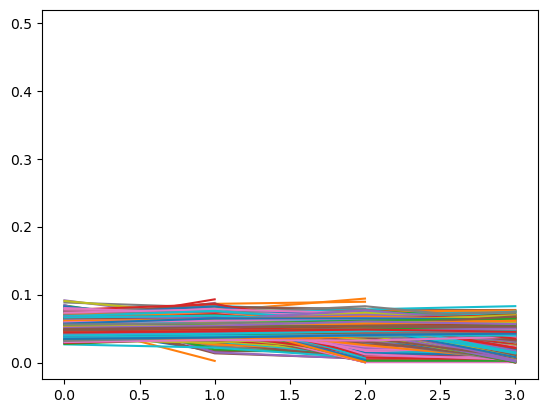

In [322]:
plt.clf()
for o_instance in instances:
    if o_instance.n_items < 200:
        continue
    loss = []
    stuck = 0
    zr = ZeroReductor2(o_instance)
    zr.heu = heu
    #Actualizo el ruido de una feature para inserta la que depende del estado del solver
    zr.heu.features[-1] = NOverON(o_instance)
    done = False
    while not done:
        instance = zr.instance
        x = heu.gen_x(instance).T
        y = encode_bool_vec(zr.instance.get_feature(IsInOptSol())).view(-1, 1)
        if len(y) == 0:  #Si la instancia no tiene solucion, no se usa :D (Las instancias mas pequeñas tienen ese riesgo)
            continue
        heu.optimizer.zero_grad()
        total_loss = 0
        y_pred = heu.net(x)
        batch_loss = heu.criterion(y_pred, y)
        batch_loss.backward()
        heu.optimizer.step()
        zr.step(max_step=100)
        old_n_items = zr.instance.n_items
        if zr.instance.n_items != old_n_items:
            stuck = 0
        else:
            stuck += 1
        if torch.min(zr.actual_pred
                     ) > 0.01 or stuck > 3 or zr.instance.n_items < 150:
            done = True
        total_loss += batch_loss.item()
        loss.append((total_loss / 2, instance))
        sys.stdout.write(
            f'\rEpoch {epoch},Presicion {1-(total_loss/2)} {str(instance)}')
        sys.stdout.flush()
    plt.plot([i for i in range(len(loss))], [i[0] for i in loss])


In [323]:
#heu.save(Path("/home/mixto/repositories/PRKP/models/DHEUV2_expanded.model"))

In [324]:
for tupla in loss[:2000]:
    print(tupla[0],str(tupla[1]))

0.049490143141198345 Instance(2500,50,#8736655684729)
0.05185620170610355 Instance(2400,50,#8736336642969)
0.05436877916533162 Instance(2300,50,#8736336642873)
0.053105883258327456 Instance(2200,50,#8736336642813)


Presicion 79.076%
STD 23.019%


(array([63., 17.,  8.,  0.,  0.,  1.,  3.,  0.,  2.,  6.]),
 array([0.05720234, 0.1472682 , 0.23733406, 0.32739992, 0.41746578,
        0.50753164, 0.5975975 , 0.68766336, 0.77772922, 0.86779508,
        0.95786094]),
 <BarContainer object of 10 artists>)

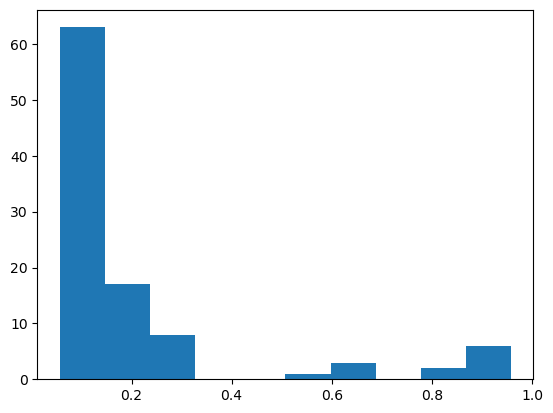

In [325]:
losses = []
with torch.no_grad():
    for instance in evaluation_instances:
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0:
            continue
        y_pred = heu.net(x)
        eval_loss = heu.criterion(y,y_pred)
        losses.append(eval_loss)
precision = (1-np.average(losses))*100
desviacion_estandar = (np.std(losses))*100
print(f"Presicion {np.round(precision,3)}%")
print(f"STD {np.round(desviacion_estandar,3)}%")

plt.hist(losses)